In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dropout
%matplotlib inline  
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers, models

In [157]:
print(tf.__version__)

2.10.1


In [158]:
def prepareData():
    allData = pd.read_csv("data/songs_with_genre.csv", index_col=0, header=[0, 1, 2])
    genres = allData["genre_id"]
    genres_index = pd.read_csv("data/genres_index.csv", index_col=0)
    allData.drop(columns=["genre_id"], inplace=True)
    data_x = allData
    data_x.columns = range(data_x.shape[1])
    #normalizing
    mu = np.mean(data_x, axis=0)
    sigma = (np.std(data_x, axis=0))
    data_x = (data_x - mu) / sigma
    #Creating the right labels
    genres.columns = range(genres.shape[1])
    targets = OneHotEncoder().fit_transform(genres_index).toarray()
    genres[0] = genres[0] - 1
    data_y = [targets[i - 1] for i in genres[0]]
    genres[0] = data_y
    
    test = genres.copy()
    test.rename(columns={0: "oneHotVector"}, inplace=True)
    test.shape
    split = pd.DataFrame(test["oneHotVector"].to_list(), columns=range(161))
    split.index = genres.index
    genres = split
    return data_x, genres

In [159]:
data_x, labels = prepareData()
x_train, x_rest, y_train, y_rest = train_test_split(data_x, labels, train_size=0.8)
x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)
print(x_train.shape), print(len(y_train))
print(x_valid.shape), print(len(y_valid))
print(x_test.shape), print(len(y_test))

(39678, 518)
39678
(4960, 518)
4960
(4960, 518)
4960


(None, None)

In [160]:
# Parameters

# Layers
kernel_size = 3
pool_size = 2
starting_filters = 32
activation_func_layer = 'relu'
activation_func_end = 'softmax'
padding_method = 'same'
optimizer_func = 'adam'
dropout = 0.5

# Fit
loss_function = 'categorical_crossentropy'
epochs = 10
batch_size = 102

# Halt
halt_monitor = 'val_accuracy'
halt_mod = 'max'
patience = 10

In [161]:
n_features, n_outputs = x_train.shape[1], y_train.shape[1]
CNN = models.Sequential()
CNN.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(n_features, 1), padding='same'))
CNN.add(layers.MaxPooling1D(pool_size=4))
CNN.add(layers.Conv1D(filters=64, kernel_size=6, activation='relu'))
CNN.add(layers.MaxPooling1D(pool_size=4))
CNN.add(layers.Dropout(0.4))
CNN.add(layers.Conv1D(filters=128, kernel_size=6, activation='relu'))
CNN.add(layers.MaxPooling1D(pool_size=4))
CNN.add(layers.Dropout(0.45))
CNN.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
CNN.add(layers.MaxPooling1D(pool_size=4))
CNN.add(layers.Dropout(0.5))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(n_outputs, activation='softmax'))


In [162]:
CNN.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_47 (Conv1D)          (None, 518, 32)           192       
                                                                 
 max_pooling1d_46 (MaxPoolin  (None, 129, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_48 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 max_pooling1d_47 (MaxPoolin  (None, 31, 64)           0         
 g1D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 31, 64)            0         
                                                                 
 conv1d_49 (Conv1D)          (None, 26, 128)         

In [163]:
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [164]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode="max", patience=50)]
training = CNN.fit(x_train, y_train, epochs=5000, validation_data=(x_valid, y_valid), batch_size=389, callbacks=callback)


Epoch 1/5000
102/102 [==============================] - 14s 135ms/step - loss: 2.2934 - accuracy: 0.2456 - val_loss: 2.0267 - val_accuracy: 0.3274
Epoch 2/5000
102/102 [==============================] - 15s 143ms/step - loss: 1.8767 - accuracy: 0.3480 - val_loss: 1.8014 - val_accuracy: 0.4234
Epoch 3/5000
102/102 [==============================] - 15s 144ms/step - loss: 1.7355 - accuracy: 0.4044 - val_loss: 1.6365 - val_accuracy: 0.4659
Epoch 4/5000
102/102 [==============================] - 14s 142ms/step - loss: 1.6450 - accuracy: 0.4368 - val_loss: 1.5393 - val_accuracy: 0.4859
Epoch 5/5000
102/102 [==============================] - 15s 147ms/step - loss: 1.5749 - accuracy: 0.4660 - val_loss: 1.5029 - val_accuracy: 0.5060
Epoch 6/5000
102/102 [==============================] - 14s 141ms/step - loss: 1.5268 - accuracy: 0.4847 - val_loss: 1.4481 - val_accuracy: 0.5218
Epoch 7/5000
102/102 [==============================] - 14s 142ms/step - loss: 1.4802 - accuracy: 0.5057 - val_loss: 1

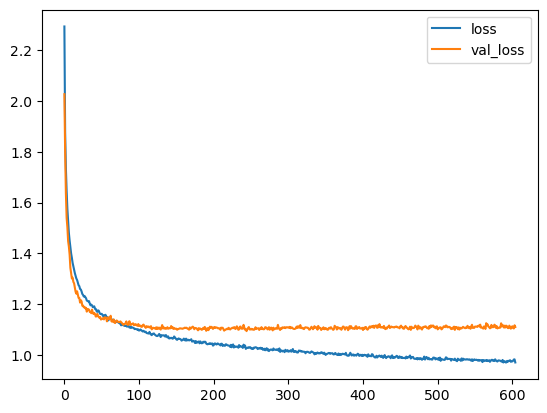

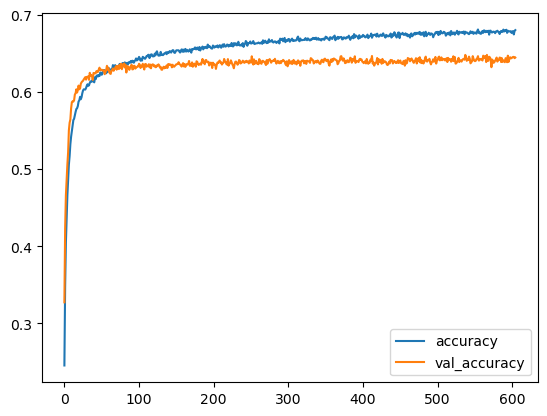

In [165]:
metrics_df = pd.DataFrame(training.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();# The semicolon prevents certain matplotlib items from being printed.

In [166]:
metrics_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.293382,0.245602,2.026659,0.327419
1,1.876667,0.348001,1.801351,0.423387
2,1.735506,0.404405,1.636547,0.465927
3,1.644972,0.436816,1.539290,0.485887
4,1.574892,0.465976,1.502914,0.506048


In [167]:
x_train.shape

(39678, 518)

In [168]:
y_train.shape

(39678, 161)

In [169]:
y_train

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
track_id,,,,,,,,,,,,,,,,,,,,,
132467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27283,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
127624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:

test_loss, test_accuracy = CNN.evaluate(x_train, y_train, verbose=2)

1240/1240 - 9s - loss: 0.8060 - accuracy: 0.7660 - 9s/epoch - 7ms/step


In [171]:
test_accuracy

0.76604163646698